In [5]:
RPM_SPEED = 4175
ENCODER_TICKS_PER_REV = 4096

In [6]:
native_speed_per_100ms = RPM_SPEED * (1 / 60.0) * (1 / 10.0) * ENCODER_TICKS_PER_REV

In [7]:
f_gain = (1.00 * 1023) / native_speed_per_100ms

In [8]:
print f_gain

0.0358930576347


In [9]:
(1023 * 0.10) / 50 

2.0460000000000003

In [2]:
kMaxSpeed = 15
kA = 7.5
kD = 5

setpoint = 1.5

In [3]:
1/ .01

100.0

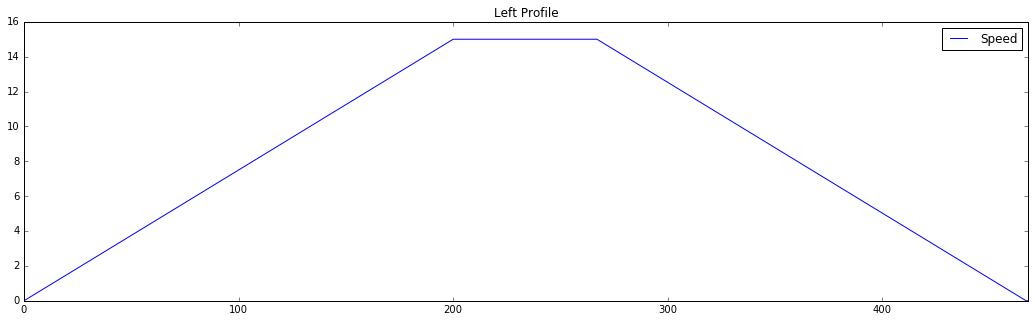

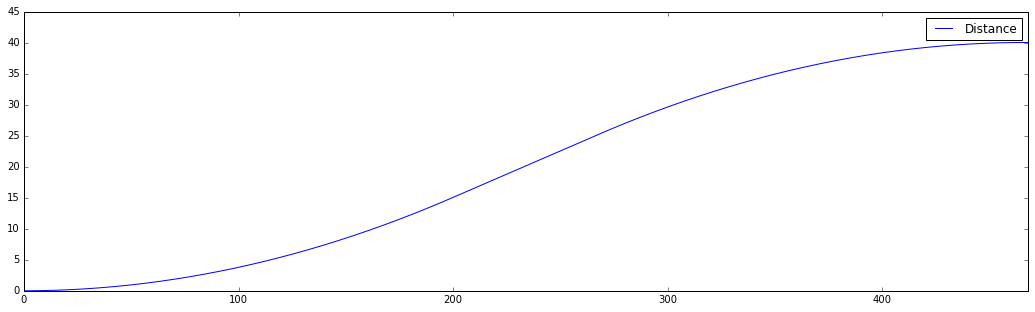

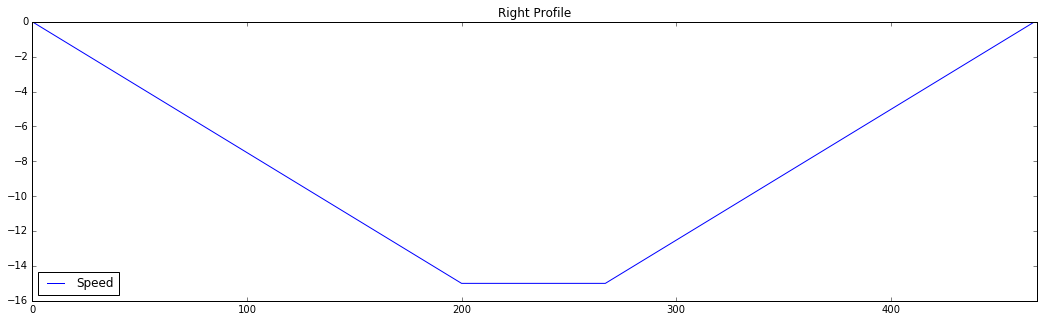

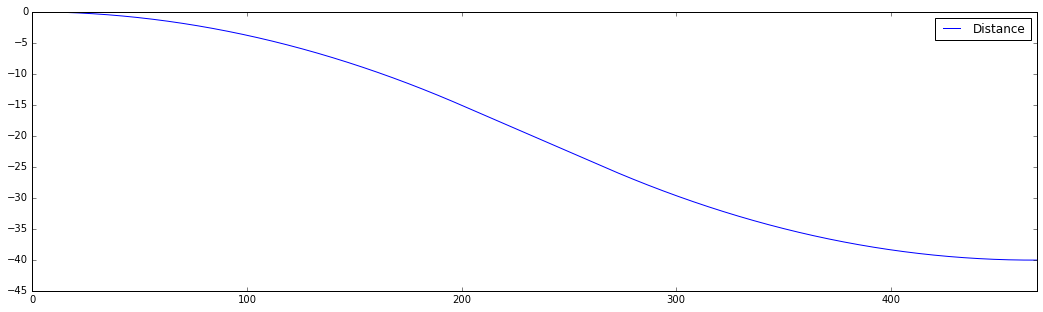

In [5]:
%matplotlib inline
import os
import re
import struct
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt

class ProfileGenerator(object):
    
    def __init__(self):
        self.kPeriod = .01
        self.kMaxSpeed = 15.0
        self.kA = 7.5
        self.kD = 7.5
        self.kJ = 3.75
        
        self.invert = False
        self.step = 0
        self.acceration = 0
        self.speed = 0
        self.distance = 0
        self.setpoint = 0
        self.distanceToStop = 0
        self.state = 0
        
        self.speeds = []
        self.distances = []
        self.times = []
        self.states = []
        
    def generate_profile(self, setpoint):
        self.setpoint = setpoint
        self._add_to_profile()
        self._generate_start()
        self._generate_cruise()
        self._generate_stop()
        
    def _generate_start(self):
        self.state = 0
        while self.speed < self.kMaxSpeed:
            self.step += 1
            
            self.speed += (self.kA * self.kPeriod)
            self.speed = min(self.kMaxSpeed, self.speed)
            
            self.distance += (self.speed * self.kPeriod)
            
            self._add_to_profile()
            
            if self.distance >= self.setpoint / 2.0:
                break
                
        self.distanceToStop = self.distance
    
    def _generate_stop(self):
        self.state = 2
        while self.speed > 0:
            self.step += 1
            
            self.speed -= (self.kA * self.kPeriod)
            self.speed = max(0, self.speed)
            
            self.distance += (self.speed * self.kPeriod)
            
            self._add_to_profile()
            
    def _generate_cruise(self):
        self.state = 1
        while self.distance + self.distanceToStop < self.setpoint:
            self.step+= 1
            
            self.distance += (self.speed * self.kPeriod)
            
            self._add_to_profile()

    def _add_to_profile(self):
        if self.invert:
            distance = -self.distance
            speed = -self.speed
        else:
            distance = self.distance
            speed = self.speed
            
        self.speeds.append(speed)
        self.distances.append(distance)
        self.times.append(self.step)
        self.states.append(self.state)

    def to_df(self):
        return pd.DataFrame({'Distance': pd.Series(self.distances),
                                'Speed': pd.Series(self.speeds), 
                                'State': pd.Series(self.states)}, 
                            index=pd.Series(self.times))
        
pg = ProfileGenerator()
pg.generate_profile(40.25)
df = pg.to_df()
df.Speed.plot(title="Left Profile", figsize=(18,5), legend=True)
plt.figure()
df.Distance.plot(figsize=(18,5), legend=True)

plt.figure()
pg = ProfileGenerator()
pg.invert = True
pg.generate_profile(40.25)
df = pg.to_df()
df.Speed.plot(title="Right Profile", figsize=(18,5), legend=True)
plt.figure()
df.Distance.plot(figsize=(18,5), legend=True)

In [275]:
kj * mPeriod

30.0

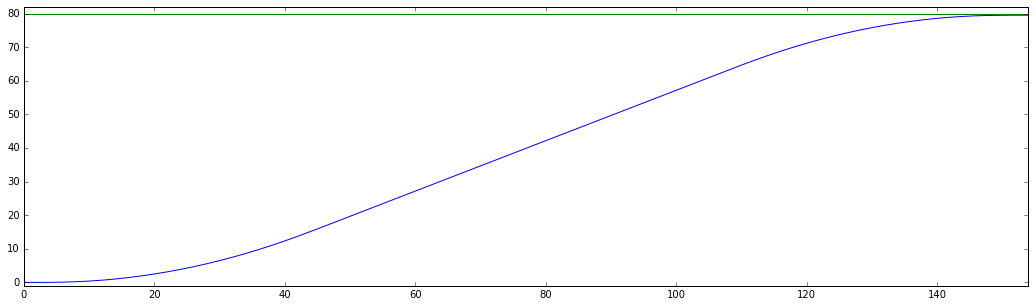

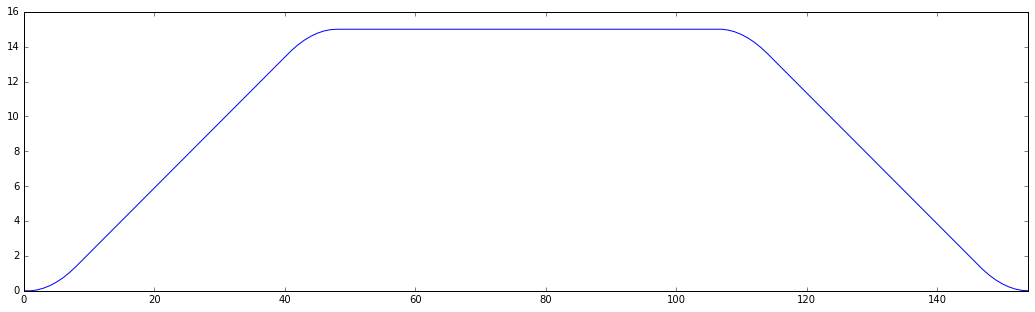

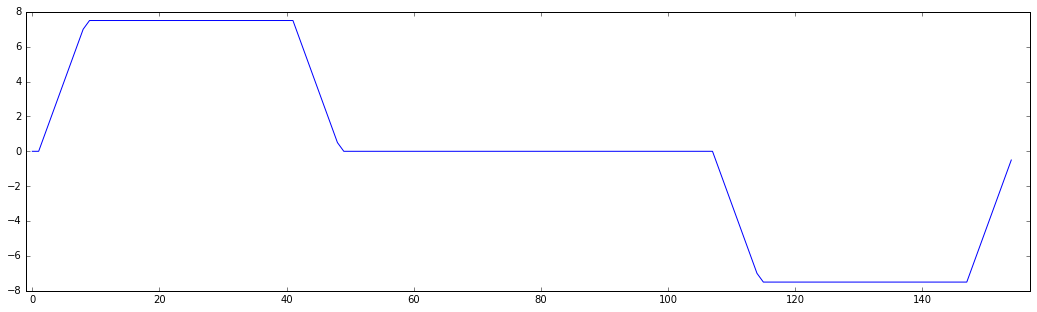

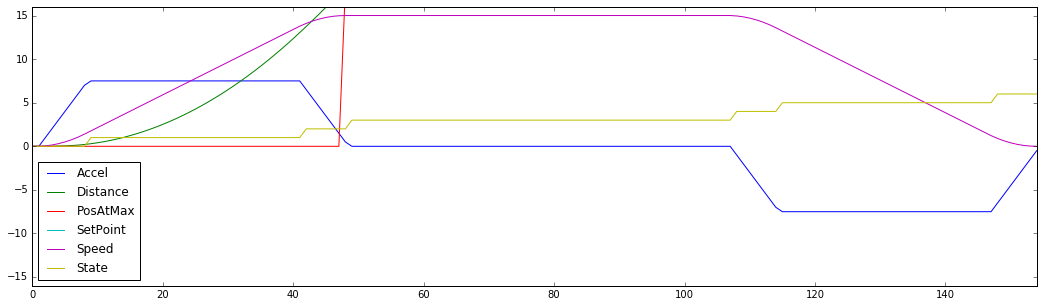

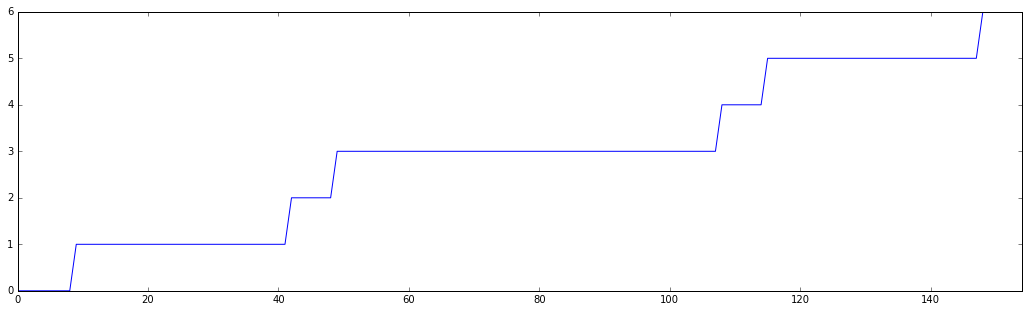

In [322]:
ka = 0
kj = 20
kv = 0

kMaxSpeed = 15
kMaxAccel = 7.5

mState = 0
mAccel = 0
mSpeed = 0
mPos = 0

mSpeedAtMaxAccel = 0
mPosAtMaxSpeed = 0

mPeriod = .05

mSetpoint = 80.0

speeds = []
distances = []
times = []
states = []
accels = []
posAtMaxSpeed = []
setpoints = []


step = 0

speeds.append(mSpeed)
distances.append(mPos)
times.append(step)
states.append(mState)
accels.append(mAccel)
setpoints.append(mSetpoint)

while (True):
        
    mSpeed = max(min(mSpeed + (mAccel * mPeriod), kMaxSpeed), 0)
    mPos = mPos + (mSpeed * mPeriod)
    
    step += 1
    
    speeds.append(mSpeed)
    distances.append(mPos)
    times.append(step)
    states.append(mState)
    accels.append(mAccel)
    setpoints.append(mSetpoint)
    
    posAtMaxSpeed.append(mPosAtMaxSpeed)
    

    
    if mState == 0:
        
        mAccel = min(mAccel + kj * mPeriod, kMaxAccel)
        
        if mAccel >= kMaxAccel:
            mSpeedAtMaxAccel = mSpeed
            mState = 1
    
    
    if mState == 1:
        #Do Nothing Special
        if mSpeed + mSpeedAtMaxAccel >= kMaxSpeed or mPos >= mSetpoint / 2.0:
            mState = 2
            
    
    if mState == 2:
        
        mAccel = max(mAccel - kj * mPeriod, 0)
        
        if mAccel <= 0:
            mPosAtMaxSpeed = mPos
            mState = 3
          
    
    if mState == 3:                
        #Do Nothing Special
        if mPos + mPosAtMaxSpeed >= mSetpoint:
            mState = 4
    

    if mState == 4:        

        mAccel = max(mAccel - kj * mPeriod, -kMaxAccel)
        
        if mAccel <= -kMaxAccel:
            mState = 5
                    
            
    if mState == 5:
        #Do Nothing Special
        if mSpeed - mSpeedAtMaxAccel <= 0:
            mState = 6
            
            
    if mState == 6:
        
        mAccel = min(mAccel + kj * mPeriod, 0)
        
        if mAccel >= 0: # or mPos >= mSetpoint:
            break
            
speeds.append(mSpeed)
distances.append(mPos)
times.append(step)
states.append(mState)
accels.append(mAccel)
setpoints.append(mSetpoint)
posAtMaxSpeed.append(mPosAtMaxSpeed)
                
a = pd.DataFrame({'Distance': pd.Series(distances),
                                'Speed': pd.Series(speeds), 
                                'State': pd.Series(states),
                                'Accel': pd.Series(accels),
                                'PosAtMax': pd.Series(posAtMaxSpeed),
                                'SetPoint': pd.Series(setpoints)}, 
                            index=pd.Series(times))

plt.figure()
ax = a.Distance.plot(figsize=(18,5))
ax = a.SetPoint.plot()
ax.set_ylim(-1,mSetpoint + 2)
# a.PosAtMax.plot(figsize=(18,5))

plt.figure()
a.Speed.plot(figsize=(18,5))

plt.figure()
ax = a.Accel.plot(figsize=(18,5))
ax.set_xlim(-1,len(a) + 1)


ax = a.plot(figsize=(18,5))
ax.set_ylim(-16,16)

plt.figure()
a.State.plot(figsize=(18,5))

In [313]:
a.Distance.max()

20.049187499999942

In [300]:
len(a) / 100.0

1.14

In [301]:
a.Speed.tail(15)

99     2.15
100    2.00
101    1.85
102    1.70
103    1.55
104    1.40
105    1.25
106    1.10
107    0.95
108    0.80
109    0.65
110    0.50
111    0.35
112    0.20
113    0.05
Name: Speed, dtype: float64

In [302]:
a.Distance.tail(15)

99     1.90325
100    1.91325
101    1.92250
102    1.93100
103    1.93875
104    1.94575
105    1.95200
106    1.95750
107    1.96225
108    1.96625
109    1.96950
110    1.97200
111    1.97375
112    1.97475
113    1.97500
Name: Distance, dtype: float64

In [303]:
a.Accel.tail(30)

84    -30
85    -30
86    -30
87    -30
88    -30
89    -30
90    -30
91    -30
92    -30
93    -30
94    -30
95    -30
96    -30
97    -30
98    -30
99    -30
100   -30
101   -30
102   -30
103   -30
104   -30
105   -30
106   -30
107   -30
108   -30
109   -30
110   -30
111   -30
112   -30
113   -30
Name: Accel, dtype: float64

In [304]:
a.head()

,Accel,Distance,PosAtMax,SetPoint,Speed,State
0,0,0.00000,0,2,0.00,0
1,30,0.00000,0,2,0.00,1
2,30,0.00075,0,2,0.15,1
3,30,0.00225,0,2,0.30,1
4,30,0.00450,0,2,0.45,1
